# Import

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy 

In [2]:
#import data and subset meaningful columns
df = pd.read_csv('/Users/zachstone/notebooks/modulargrid/modulargrid_scrape-main/modules.csv')
df = df[['manufacturer_name', 
         'module_name', 
         'module_type',
         'width',
         'depth',
         'current_plus12V','current_minus12V','current_5V',
         'price',
         'num_racks',
         'tags',
         'availability']]

## Prep

In [88]:
#subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
moduledf['tags'] = moduledf['tags'].str.lower()

#Drop accessories
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander|blank panel')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Flag unknown brands
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')

#Get branded modules
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]

#Add log_price and log_racks
df_brands['log_price'] = np.log(df_brands['price'])
df_brands['log_racks'] = np.log(df_brands['num_racks'])


#Make dfs exploded over function
df_brands['functions'] = df_brands.tags.str.split('-')
brands_exploded = df_brands.explode('functions')

#Multi vs. single function flag
df_brands['multifunction'] = df_brands['functions'].apply(lambda x: len(x)>1)

#Known price flag
df_brands['price_known'] = df_brands.price.notnull()


# moduledf['functions'] = moduledf.tags.str.split('-')
# modules_exploded = moduledf.explode('functions')

numeric = ['width', 'price', 'log_price', 'num_racks', 'log_racks']

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_46762/4161086166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf.drop('module_type', axis =1, inplace=True)
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_46762/4161086166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf['tags'] = moduledf['tags'].str.lower()
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_46762/4161086166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [6]:
# brand_dummy = pd.get_dummies(df_brands, columns = ['manufacturer_name']).drop(['depth', 'current_plus12V', 'current_minus12V','current_5V'], axis = 1)

In [4]:
df_brands.columns

Index(['manufacturer_name', 'module_name', 'width', 'depth', 'current_plus12V',
       'current_minus12V', 'current_5V', 'price', 'num_racks', 'tags',
       'availability', 'brand_known', 'log_price', 'log_racks', 'functions',
       'multifunction'],
      dtype='object')

In [5]:
df_brands[numeric].describe()

,width,price,log_price,num_racks,log_racks
count,7066.000000,6337.000000,6337.000000,7066.000000,7066.000000
mean,11.425984,205.569355,5.009676,750.310784,5.076368
std,10.099868,192.082718,0.821428,2282.390905,1.744566
min,1.000000,4.000000,1.386294,1.000000,0.000000
25%,6.000000,90.000000,4.499810,45.000000,3.806662
50%,8.000000,160.000000,5.075174,142.000000,4.955827
75%,14.000000,259.000000,5.556828,536.750000,6.285532
max,104.000000,3999.000000,8.293800,52604.000000,10.870547


# EDA
modulesdf contains all eurorack modules, even without brand name, with 'accessories' (blank panels, power strips, expanders) dropped. About 20% of all modules are missing price.

brand_df is the subset for modules with brand names listed. About 10% of prices are missing for branded modules.

Some useful but non-obvious business questions: 
1) What functions are optimal for single-use modules? What are their optimal sizes and pricings?
2) What functions are optimal for multi-use modules? What are their optimal sizes and pricings?
3) What are good choices for combinations of functions for multi-use modules? Are certain groupings more popular at certain sizes? What price points are good for that?
4) What 'gaps' might exist for multi-use modules? E.g. popular functions at that size and price point.

These will have to be broken up. We should look at:
-general correlations

a) popularity of different types

b) size distribution of different types

c) price vs popularity

d) for each type, to what extent does price vs size vs brand vs combos predict popularity

Plan:
1. Single variable
- Distribution for price
- Popularity
- Width

2. Categorical variables
- popularity and function

3. Comparison of variables
- correlation between numerical variables
- popularity and price for single vs multifunction
- size against popularity by function and single vs. multifunction
- brand and popularity
- How many/what functions does each brand make? If there is a difference in number of functions each brand makes?

# Single variable stats

## Price and functionality

Price is somewhat log-normal, but has some irregularities.

Mean price is different for single and multifunction modules with p<0.01. For single function modules, log(price) is much closer to normal. However, for multifunction, it is left-skewed. Other factors may be at play, such as number of functions or types of functions.

(array([   7.,   42.,  232.,  567., 1644., 2210., 1277.,  317.,   36.,
           5.]),
 array([1.38629436, 2.07704489, 2.76779541, 3.45854594, 4.14929646,
        4.84004698, 5.53079751, 6.22154803, 6.91229856, 7.60304908,
        8.29379961]),
 <BarContainer object of 10 artists>)

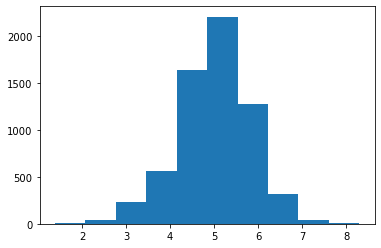

In [7]:
plt.hist(np.log(df_brands.price))

<AxesSubplot:xlabel='price', ylabel='Density'>

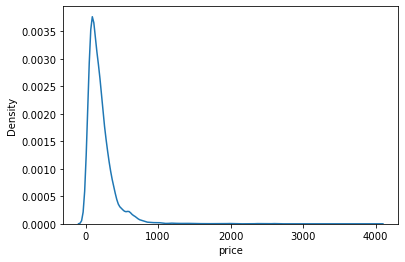

In [8]:
sns.kdeplot(df_brands.price)

We check log_price

<AxesSubplot:xlabel='price', ylabel='Density'>

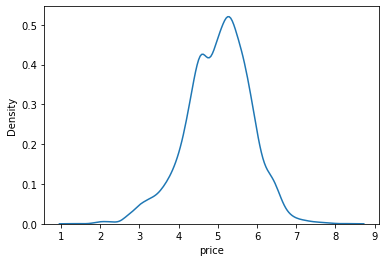

In [9]:
sns.kdeplot(np.log(df_brands.price))

In [14]:
scipy.stats.describe(df_brands.log_price.dropna().values)

DescribeResult(nobs=6337, minmax=(1.3862943611198906, 8.293799608846818), mean=5.009675841278094, variance=0.6747437410949441, skewness=-0.3363614073023695, kurtosis=0.4946002837322361)

In [59]:
mean_log_price, std_log_price = np.log(df_brands[df_brands.price.notnull()].price).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

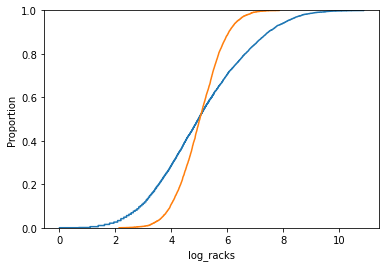

In [61]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_price, scale = std_log_price, size = 5000), ax=ax)

log(price) better behaved, but still not perfectly normal. Like with size, better distributions may hold among subclasses. We first check single vs. multifunction.

Text(0.5, 1.0, 'Multifunction vs. Price')

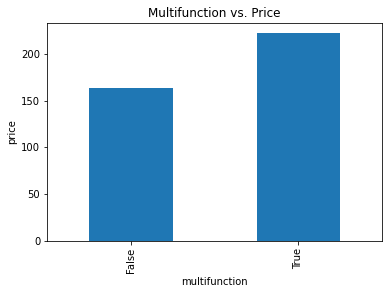

In [54]:
ax = df_brands.groupby('multifunction')['price'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('price')
ax.set_title('Multifunction vs. Price')

In [51]:
multifunction_price = df_brands[df_brands.multifunction].loc[df_brands.price.notnull()].loc[:,'price'].values
singlefunction_price = df_brands[~df_brands.multifunction].loc[df_brands.price.notnull()].loc[:,'price'].values

In [52]:
ttest_ind(multifunction_price, singlefunction_price, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=12.468926664514205, pvalue=2.1038616105596615e-35)

We can see that single vs. multifunction come from different price distributions with different means.

In [68]:
single_price_mean, single_price_std = (np.mean(np.log(singlefunction_price)), np.std(np.log(singlefunction_price)))

<AxesSubplot:ylabel='Proportion'>

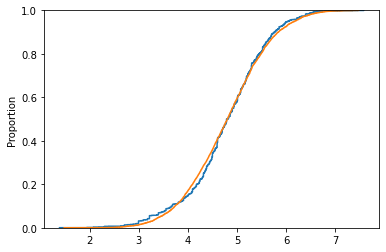

In [70]:
fig, ax = plt.subplots()

sns.ecdfplot(np.log(singlefunction_price), ax =ax)
sns.ecdfplot(np.random.normal(loc = single_price_mean, scale = single_price_std, size = 5000), ax=ax)

Log(price) for single-function is much closer to normal. We now check multifunction.

In [72]:
multi_price_mean, multi_price_std = (np.mean(np.log(multifunction_price)), np.std(np.log(multifunction_price)))

<AxesSubplot:ylabel='Proportion'>

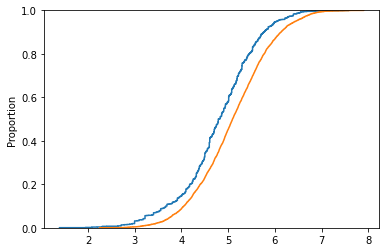

In [73]:
fig, ax = plt.subplots()

sns.ecdfplot(np.log(singlefunction_price), ax =ax)
sns.ecdfplot(np.random.normal(loc = multi_price_mean, scale = multi_price_std, size = 5000), ax=ax)

In [80]:
scipy.stats.describe(np.log(multifunction_price))

DescribeResult(nobs=4531, minmax=(1.9459101490553132, 8.293799608846818), mean=5.099760316272254, variance=0.6457421205565778, skewness=-0.33471108189064325, kurtosis=0.512077292382076)

log_price for multifunction is skewed left

## Popularity
Based on num_racks is almost exactly log-normal. log(num_racks) can be treated like a normally distributed quantity.

<AxesSubplot:ylabel='Frequency'>

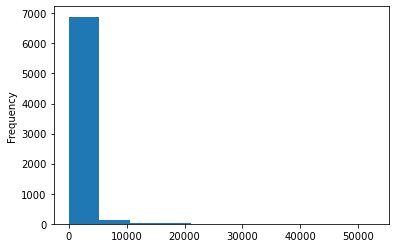

In [15]:
df_brands.num_racks.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

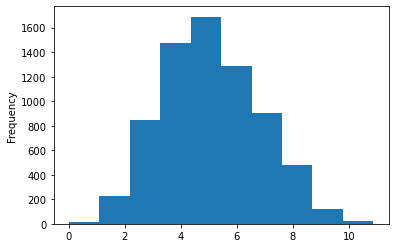

In [16]:
np.log(df_brands.num_racks).plot(kind='hist')

In [17]:
mean_log_pop, std_log_pop = np.log(df_brands.num_racks).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

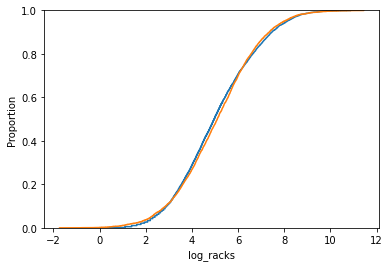

In [18]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_pop, scale = std_log_pop, size = 5000), ax=ax)

log(num_racks) better behaved

## Size (width in hp)

More idiosyncratic distribution. While there are certain highly frequent sizes, the distribution is not (log-)normal, and the frequent sizes aren't necessarily more popular. A typical distribution and correlation with popularity may only hold within certain subgroups, if at all.

However, the distributions of multi and single function modules do have significantly different means, which should be kept in mind when looking at comparisons against width.

<AxesSubplot:ylabel='Frequency'>

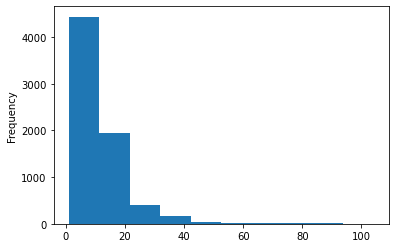

In [19]:
df_brands.width.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

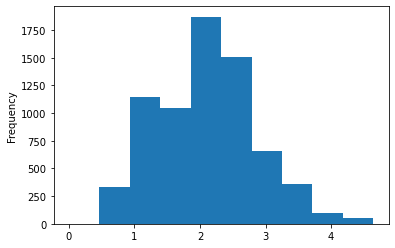

In [20]:
np.log(df_brands.width).plot(kind='hist')

<AxesSubplot:xlabel='width', ylabel='Density'>

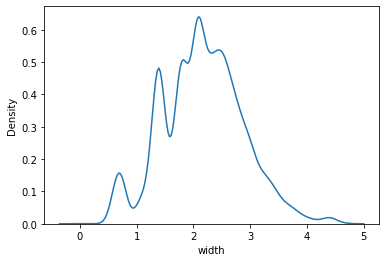

In [21]:
sns.kdeplot(np.log(df_brands.width)) 

Sizes have more unusual distribution. First check against single vs. multifunction.

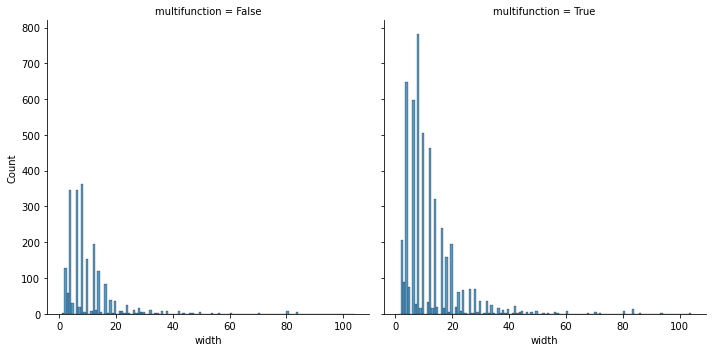

In [22]:
sns.displot(x= 'width', data = df_brands, col = 'multifunction', kind = 'hist', log_scale = False)

Some irregularities are teased apart into the two groups. We look more closely at their distribution, and check that their means are significantly different.

In [23]:
def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

def cutoff(dist):
    return np.percentile(dist,75) + 1.5 * IQR(dist)

In [24]:
df_brands.groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.109948   9.393301  8.0
True           11.982880  10.334958  8.0

In [25]:
df_brands[df_brands.price.notnull()].groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False          10.033776   9.288928  8.0
True           11.834253  10.168541  8.0

Single and multi-use modules have similar width distributions, with multifunction being larger by about 2hp.

We can check if the difference is signficant with a 2-sample ttest with p=0.05.

In [26]:
from scipy.stats import ttest_ind

In [27]:
multifunction_w = df_brands[df_brands.multifunction].loc[:,'width'].values
singlefunction_w = df_brands[~df_brands.multifunction].loc[:,'width'].values

In [28]:
ttest_ind(multifunction_w, singlefunction_w, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=7.431973571153125, pvalue=6.412489290295425e-14)

The result is significant, so we can assume they come from different distributions.

We also note that visual inspection shows some very frequent sizes. It may be that these sizes are 'standards' which skew the distribution. In this way, the frequent sizes may be more like ordered categoricals/classes.

In [29]:
# df_brands.width.value_counts(sort=True, normalize=True).iloc[::-1].plot(kind='barh', figsize = (5,12))

In [30]:
df_brands.width.value_counts(sort=True, normalize=True).head(20)

8.0     0.161902
4.0     0.140815
6.0     0.133456
10.0    0.092980
12.0    0.092980
14.0    0.062412
2.0     0.047269
16.0    0.045429
20.0    0.032692
18.0    0.028022
3.0     0.020804
5.0     0.014718
24.0    0.013020
28.0    0.011746
26.0    0.011180
22.0    0.009765
7.0     0.006652
32.0    0.006652
30.0    0.005944
11.0    0.005661
Name: width, dtype: float64

We can see that after 2hp, the proportion of modules of each size quickly drops below 5% of all modules. Let's check if there are any popularity standouts by width.

In [31]:
df_brands.width.unique().size

62

We look at the popularity of each width for single and multifunction modules

<AxesSubplot:ylabel='width'>

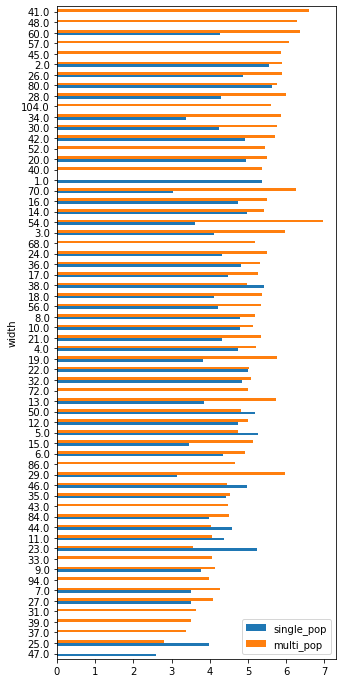

In [32]:
width_pop = df_brands.groupby(['multifunction', 'width'])[['log_racks']]\
                .mean().unstack().T.reset_index('width').reset_index(drop=True)
width_pop.columns = ['width', 'single_pop', 'multi_pop']
width_pop = width_pop.merge(df_brands.groupby('width')[['log_racks']].mean().reset_index(), on = 'width', how='outer')
width_pop.sort_values(by='log_racks').drop('log_racks', axis=1).plot(x = 'width', kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

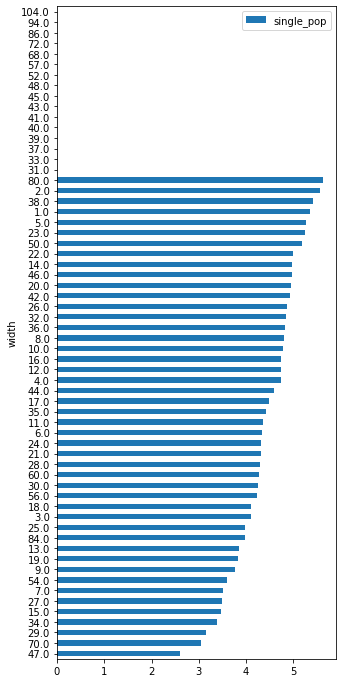

In [33]:
width_pop[['width','single_pop']].sort_values('single_pop').plot(x='width', kind = 'barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

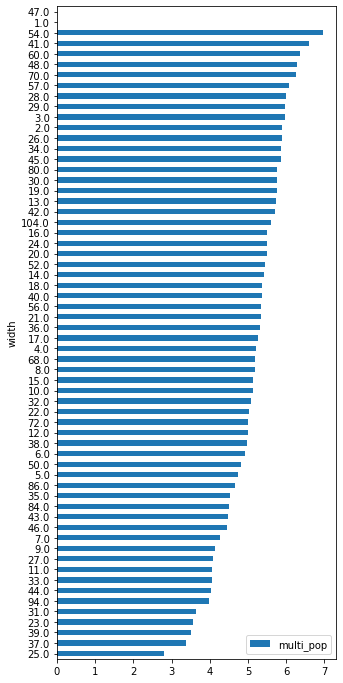

In [34]:
width_pop[['width','multi_pop']].sort_values('multi_pop').plot(x='width', kind = 'barh', figsize = (5,12))

Neither group particularly had the most frequent sizes among the most popular. It is likely popularity vs size only shows up within certain subgroups, if it is a predictor at all.

# Comparison of variables

## Popularity vs. single/multi-function

Multifunction modules are significantly more popular. We also plot basic stats like popularity of each function.

Multifunction modules will be counted in every category they are contained in when looking at stats by function. 

We will also look at multi v. single function and popularity

Text(0.5, 1.0, 'Multifunction vs. Popularity')

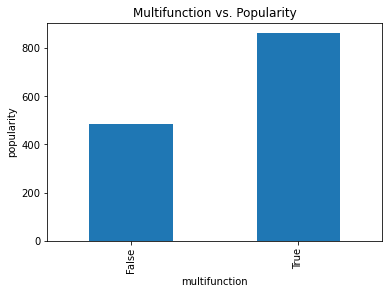

In [35]:
ax = df_brands.groupby('multifunction')['num_racks'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('popularity')
ax.set_title('Multifunction vs. Popularity')

We can clearly see that multifunction modules are more popular than single function. To verify:

In [36]:
multifunction_p = df_brands[df_brands.multifunction].loc[:,'num_racks'].values
singlefunction_p = df_brands[~df_brands.multifunction].loc[:,'num_racks'].values

In [37]:
ttest_ind(multifunction_p, singlefunction_p, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=8.063546919636027, pvalue=4.3445084120283227e-16)

In [38]:
# brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='functions'>

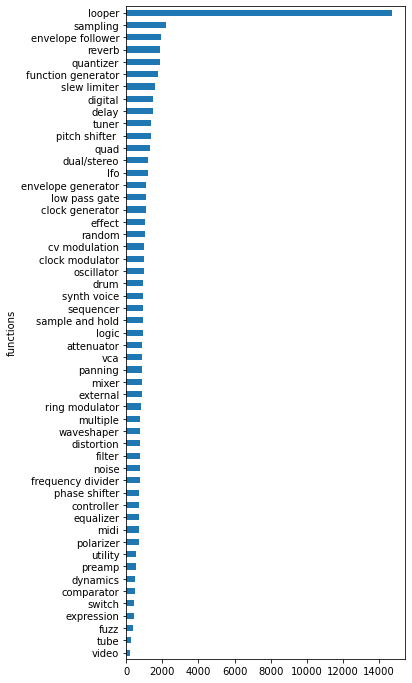

In [39]:
#All functions by popularity
brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [40]:
# modules_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [41]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values(ascending=False).index

Index(['looper', 'sampling', 'envelope follower', 'reverb', 'quantizer',
       'function generator', 'slew limiter', 'digital', 'delay', 'tuner',
       'pitch shifter ', 'quad', 'dual/stereo', 'lfo', 'envelope generator',
       'low pass gate', 'clock generator', 'effect', 'random', 'cv modulation',
       'clock modulator', 'oscillator', 'drum', 'synth voice', 'sequencer',
       'sample and hold', 'logic', 'attenuator', 'vca', 'panning', 'mixer',
       'external', 'ring modulator', 'multiple', 'waveshaper', 'distortion',
       'filter', 'noise', 'frequency divider', 'phase shifter', 'controller',
       'equalizer', 'midi', 'polarizer', 'utility', 'preamp', 'dynamics',
       'comparator', 'switch', 'expression', 'fuzz', 'tube', 'video'],
      dtype='object', name='functions')

In [42]:
brands_exploded.functions.unique().size

53

## Price and popularity

Price and popularity are almost completely decorrelated for both single and multifunction modules, with less than 25% (positive) correlation on both lin-lin and log-log scales. 

Since popularity and price are from distinct distributions for single and multi-function modules, we look at each independently.

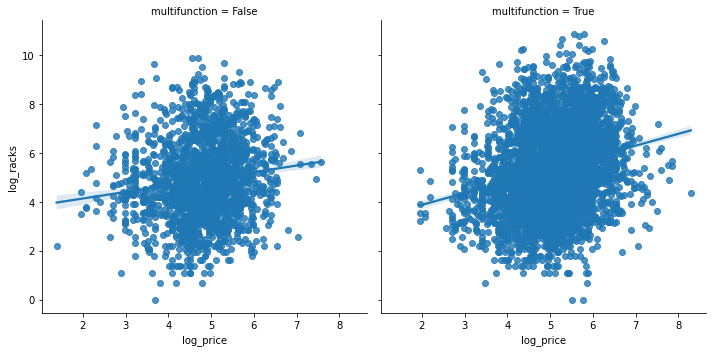

In [100]:
sns.lmplot(x = 'log_price', y = 'log_racks', data = df_brands[df_brands.price_known], col = 'multifunction')

It looks like there is a very weak positive correlation. We check numerically.

In [106]:
#Single function
df_brands[df_brands.price_known & (~df_brands.multifunction)][numeric].drop('width', axis=1).corr()

,price,log_price,num_racks,log_racks
price,1.000000,0.823255,0.038671,0.116730
log_price,0.823255,1.000000,0.061312,0.133353
num_racks,0.038671,0.061312,1.000000,0.637616
log_racks,0.116730,0.133353,0.637616,1.000000


In [107]:
#Multifunction
df_brands[df_brands.price_known & (df_brands.multifunction)][numeric].drop('width', axis=1).corr()

,price,log_price,num_racks,log_racks
price,1.000000,0.809995,0.059688,0.153549
log_price,0.809995,1.000000,0.095564,0.225221
num_racks,0.059688,0.095564,1.000000,0.563899
log_racks,0.153549,0.225221,0.563899,1.000000


Surprisingly, increased price does not seem to lead to a decrease in popularity. The correlation does not reach 25% even in the log-transformed data, so we can see that these are roughly decorrelated.

## Size vs. popularity

Size has an irregular distribution, even when separating single and multi-function modules. We may have to look within-function(s) to see patterns, if they exist.

On the whole, there are not significant correlations between size and popularity within single and multifunction groups.

First check size vs. popularity in single and multi function modules.

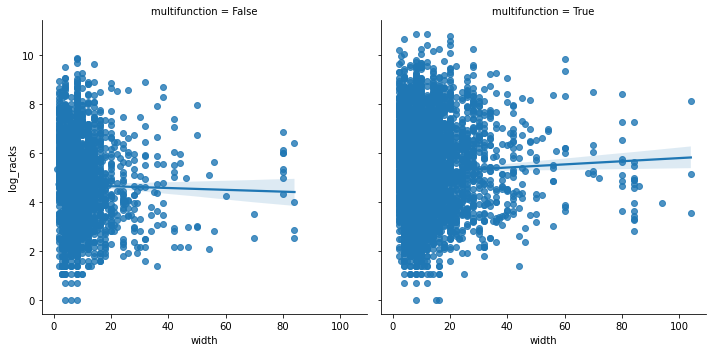

In [110]:
sns.lmplot(x = 'width', y = 'log_racks', data = df_brands, col = 'multifunction')

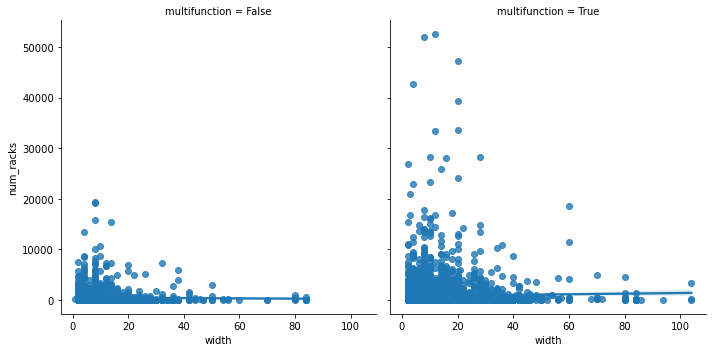

In [111]:
sns.lmplot(x = 'width', y = 'num_racks', data = df_brands, col = 'multifunction')

In [114]:
df_brands[~df_brands.multifunction][numeric].corr()

,width,price,log_price,num_racks,log_racks
width,1.000000,0.582195,0.493926,-0.020332,-0.020698
price,0.582195,1.000000,0.823255,0.038671,0.116730
log_price,0.493926,0.823255,1.000000,0.061312,0.133353
num_racks,-0.020332,0.038671,0.061312,1.000000,0.621931
log_racks,-0.020698,0.116730,0.133353,0.621931,1.000000


No significant correlations. We will have to look at size within smaller groups.

## Popularity of brands

In [121]:
#All functions by popularity
df_brands.groupby('manufacturer_name')['num_racks'].mean().sort_values(ascending=False).head(50)

manufacturer_name
Mutable instruments         20765.400000
DivKid                      14615.500000
Make Noise                   9107.326923
Intellijel                   8397.305085
Strymon                      7678.333333
Moog Music Inc.              6961.000000
Mannequins                   5105.111111
Expert Sleepers              4727.285714
Squarp Instruments           4641.666667
ALM Busy Circuits            4591.107143
Xaoc Devices                 3559.148148
Mordax                       3534.250000
Acid Rain Technology         3212.000000
Rossum Electro-Music         2998.750000
Joranalogue Audio Design     2945.625000
Five12                       2828.000000
Doepfer                      2673.248756
Verbos Electronics           2641.111111
ThreeTom Modular             2641.000000
Instruō                      2494.800000
Winter Modular               2388.333333
Epoch Modular                2305.000000
Rabid Elephant               2263.000000
Empress Effects              2206.00000

## Size, popularity, and function
XXX

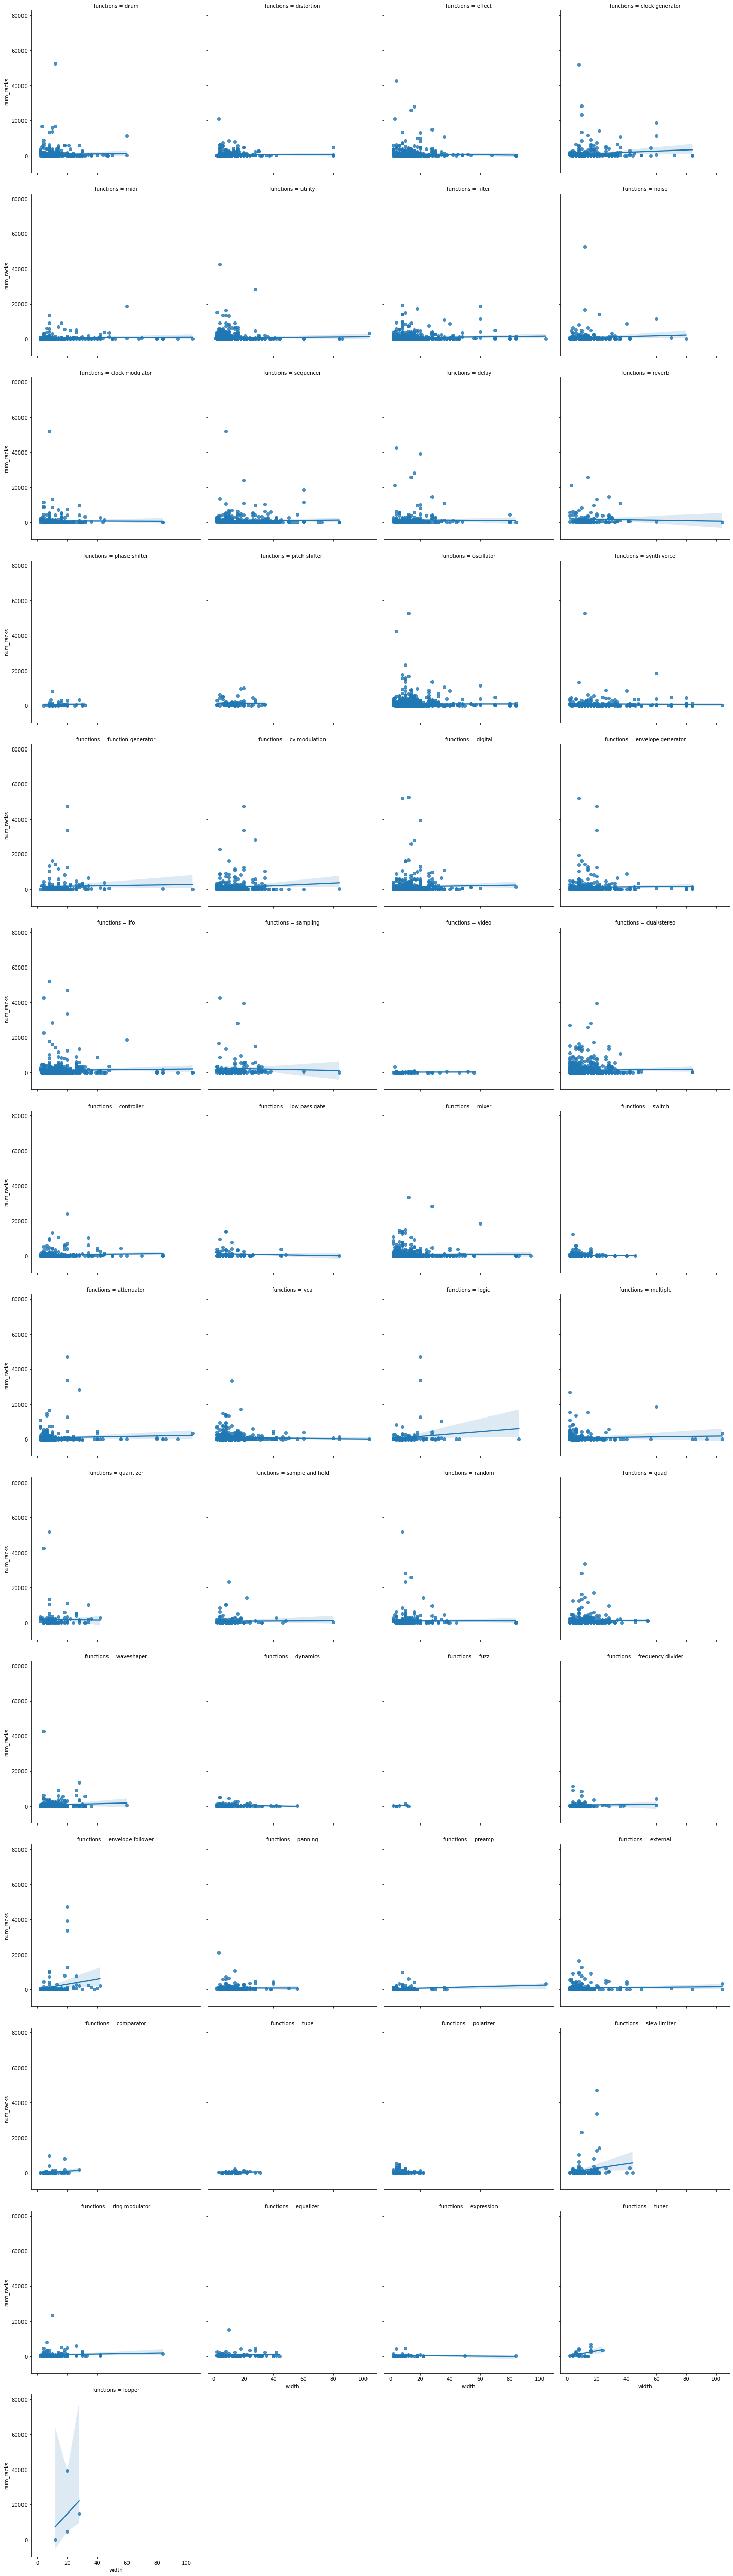

In [44]:
sns.lmplot(x = 'width', y = 'num_racks', data = brands_exploded, col = 'functions', col_wrap = 4)

As expected, the relationship between size and popularity is nonlinear, with popularity leaning towards mid-small sized modules.
To begin analysis of size, we look for size outliers in each category.

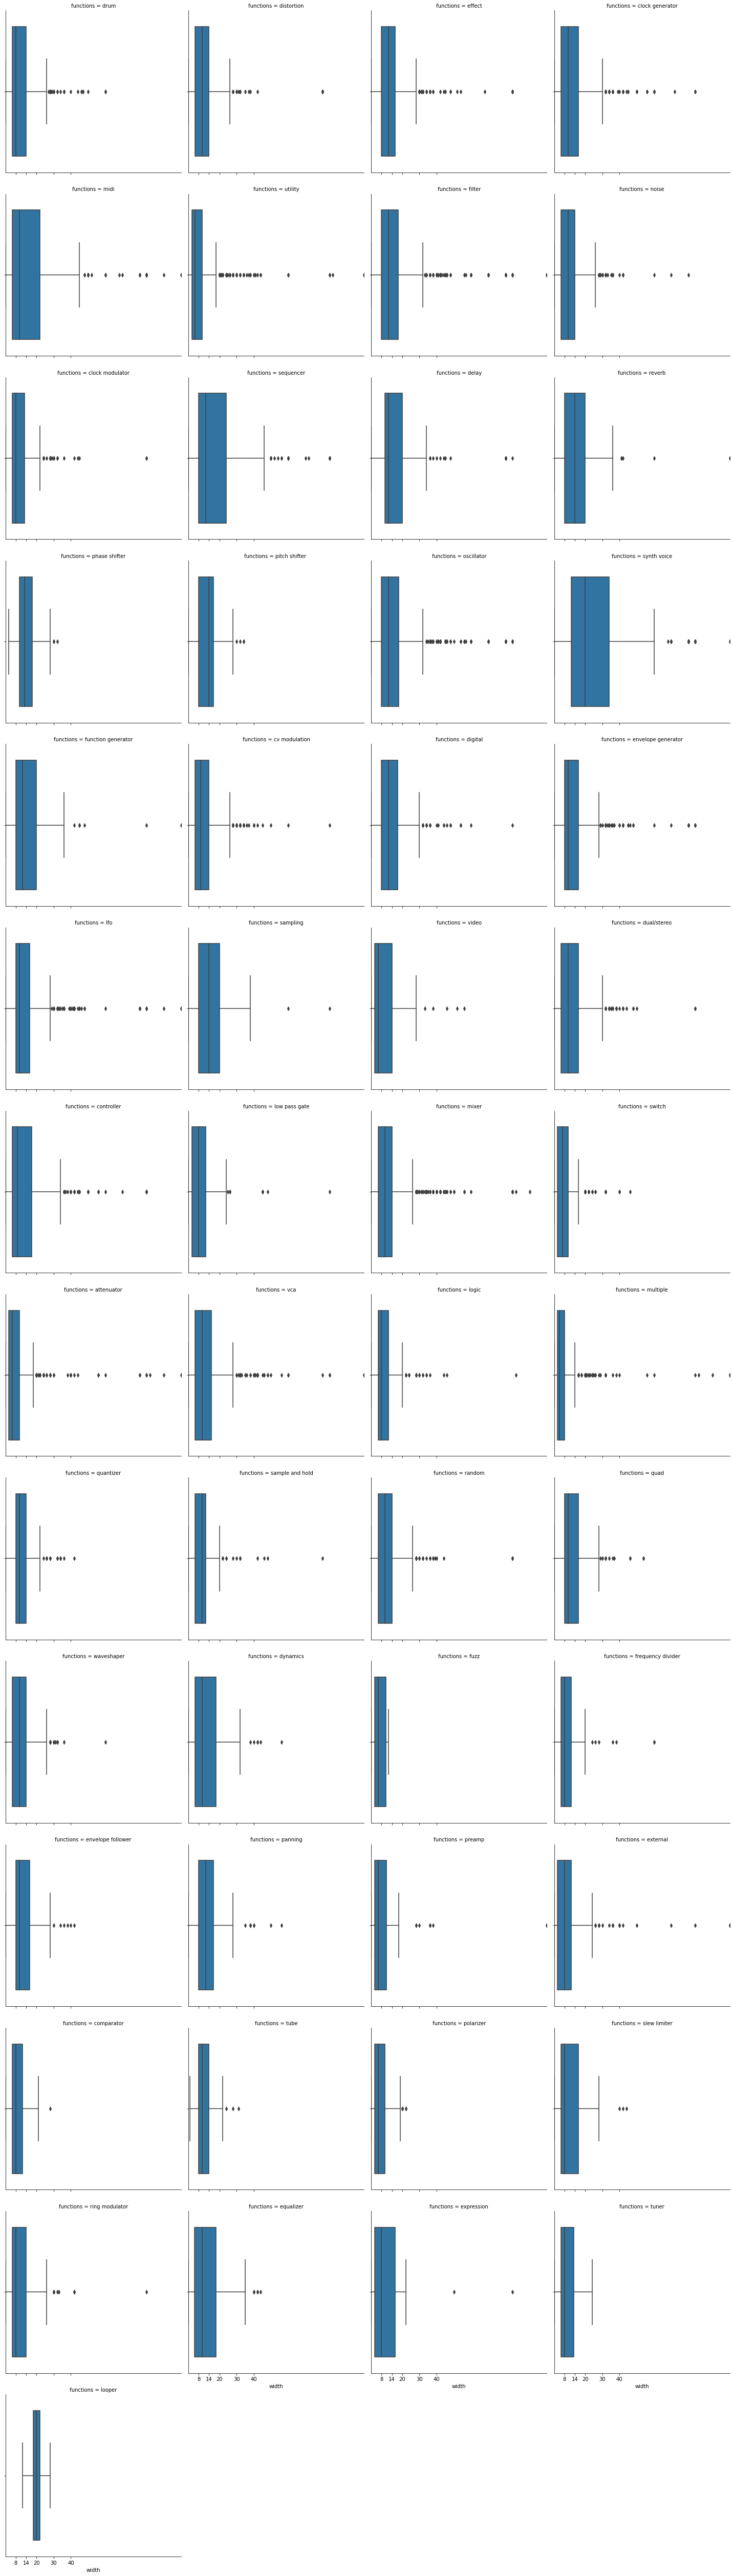

In [45]:
g = sns.catplot(x = 'width', col = 'functions', col_wrap = 4, data = brands_exploded, kind = 'box')
g.set(xlim = (2,np.max(brands_exploded.width)), xticks = [8, 14, 20, 30, 40])

The distribution of outliers over 1.5IQR above Q3 varies greatly between functions, suggesting that they may be different in each group. We should examine the outlier for each kind. This may be due to many factors, such as the outliers for certain functions being due to commonly being on multifunction modules, which may be larger.

In [46]:
function_widths = [*brands_exploded.groupby('functions')['width']]

In [47]:
#Inspecting outliers for each group may be too complicated
# print(function_widths[0][0])
# print(cutoff(function_widths[0][1]))
# np.array(function_widths[0][1:]).reshape(-1,)[(function_widths[0][1] > cutoff(function_widths[0][1:])).values]

# Questions
EDA background:
-popularity is log-normal
-price is loosely log-normal, with large tails and left skew. single function price is much closer to log-normal. less so for multi-function, which has a left skew.
-size is much more idiosyncratic, with multifunction with a significantly larger width by about 1.8 on average.


-multifunction are significantly more popular

-price and popularity are decorrelated

-size has no overall patterns with popularity, probably need more restricted product groups.

So, price is not a great predictor of popularity. We know that multifunctions modules are larger and more popular on the whole, but we will want to get a more in depth analysis by function. We want to look at relations between popularity, size, single vs. multi by function. 

- For each function, are multi-function modules containing that function more or less popular than their single-function counterparts?
-  Are there patterns among the popularity of brands based on the types or breadth of functions they produce?
- For popular functions, are there many popular modules, are a few very popular modules? Are there functions which have more room before they're 'saturated'?
- Do popular brands have many popular products accross functions, or do they tend to have more successful products within a category?


For multifunction:
- Popularity by number of functions
- Function pairings which result in highest popularity.

In [127]:
functions = brands_exploded.functions.unique()

In [129]:
test_f = np.random.choice(functions)

In [130]:
test_f

'looper'

In [133]:
singledf = df_brands[~df_brands.multifunction]
multidf = df_brands[df_brands.multifunction]